In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# set seed for reproducibility
np.random.seed(0)
df = pd.read_csv('iris.csv')

In [223]:
df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [224]:
df.info()   #informazioni sul tipo di features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [225]:
df.describe()   #analisi descrittive

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [226]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:5]

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [227]:
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

0.0

In [228]:
# remove all columns with at least one missing value

columns_with_na_dropped = df.dropna(axis=1)
columns_with_na_dropped.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [229]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % df.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 5 

Columns with na's dropped: 5


In [0]:
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['species']= label_encoder.fit_transform(df['species']) 

In [231]:
# Get column names first
names = df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(array([ 9., 23., 14., 27., 22., 20., 18.,  6.,  5.,  6.]),
 array([-1.87002413, -1.4338198 , -0.99761547, -0.56141113, -0.1252068 ,
         0.31099753,  0.74720187,  1.1834062 ,  1.61961053,  2.05581487,
         2.4920192 ]),
 <a list of 10 Patch objects>)

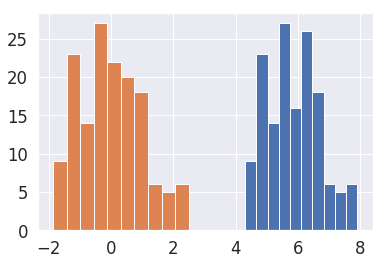

In [232]:
#plotto gli istogrammi relativi a determinate caratteristiche
plt.hist(df['sepal_length'])
plt.hist(scaled_df['sepal_length'])

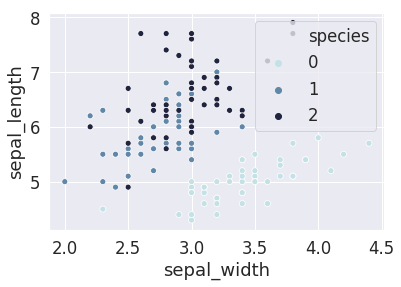

In [233]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="sepal_width", y="sepal_length",
                     hue="species",
                     palette=cmap, sizes=(10, 200),
                     data=df)

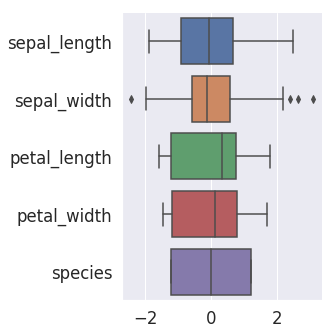

In [234]:
sns.catplot(data=scaled_df, orient="h", kind="box");


Text(0.5, 1.0, 'Scaled data')

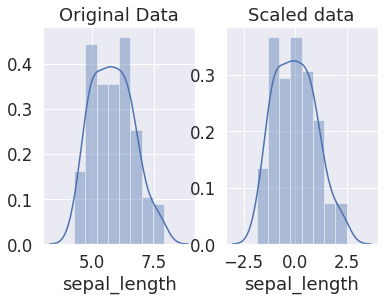

In [235]:
#plotto le distribuzioni dei dati originali e scalati
fig, ax=plt.subplots(1,2)
sns.distplot(df['sepal_length'], ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_df['sepal_length'], ax=ax[1])
ax[1].set_title("Scaled data")

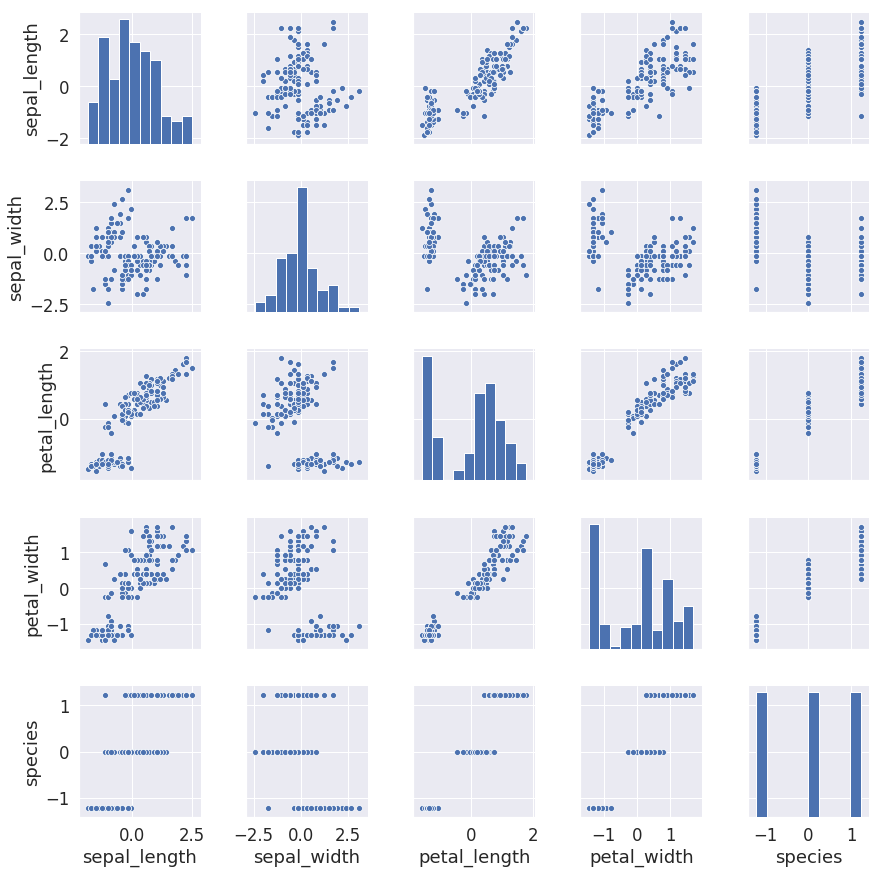

In [236]:

#plotto la correlazioni visive tra le varie variabili
sns.pairplot(scaled_df)

In [237]:
#calcolo il coeff di kurtosis
scaled_df.skew(axis = 0, skipna = True)

sepal_length    0.314911
sepal_width     0.334053
petal_length   -0.274464
petal_width    -0.104997
species         0.000000
dtype: float64

In [238]:
#valutiamo gli outliers

outliers = []

# For each feature find the data points with extreme high or low values
for feature in scaled_df.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(scaled_df[feature],25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(scaled_df[feature],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3-Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(scaled_df[~((scaled_df[feature] >= Q1 - step) & (scaled_df[feature] <= Q3 + step))])
    lista = scaled_df[~((scaled_df[feature] >= Q1 - step) & (scaled_df[feature] <= Q3 + step))].index.tolist()
    outliers.append(lista)
    
# OPTIONAL: Select the indices for data points you wish to remove


# Remove the outliers, if any were specified

Data points considered outliers for the feature 'sepal_length':


,sepal_length,sepal_width,petal_length,petal_width,species


Data points considered outliers for the feature 'sepal_width':


,sepal_length,sepal_width,petal_length,petal_width,species
15,-0.173674,3.114684,-1.284407,-1.050031,-1.224745
32,-0.779513,2.420475,-1.284407,-1.444450,-1.224745
33,-0.416010,2.651878,-1.341272,-1.312977,-1.224745
60,-1.021849,-2.438987,-0.147093,-0.261193,0.000000


Data points considered outliers for the feature 'petal_length':


,sepal_length,sepal_width,petal_length,petal_width,species


Data points considered outliers for the feature 'petal_width':


,sepal_length,sepal_width,petal_length,petal_width,species


Data points considered outliers for the feature 'species':


,sepal_length,sepal_width,petal_length,petal_width,species


In [0]:
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species']

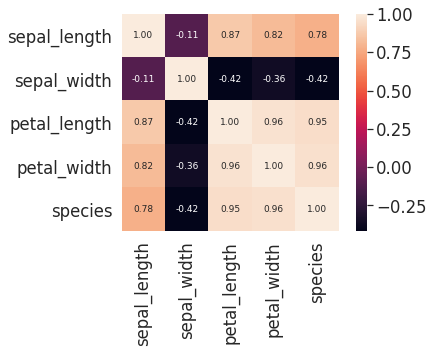

In [240]:
#matrice di correlazione
import numpy as np
cm = np.corrcoef(scaled_df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 9},yticklabels=cols,xticklabels=cols)
plt.show()

In [0]:
group_longitude = scaled_df.groupby('species')


In [242]:
group_longitude.mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
-1.224745,-1.014579,0.842307,-1.304878,-1.255129
0.000000,0.112282,-0.657184,0.285087,0.167409
1.224745,0.902297,-0.185122,1.019792,1.087720


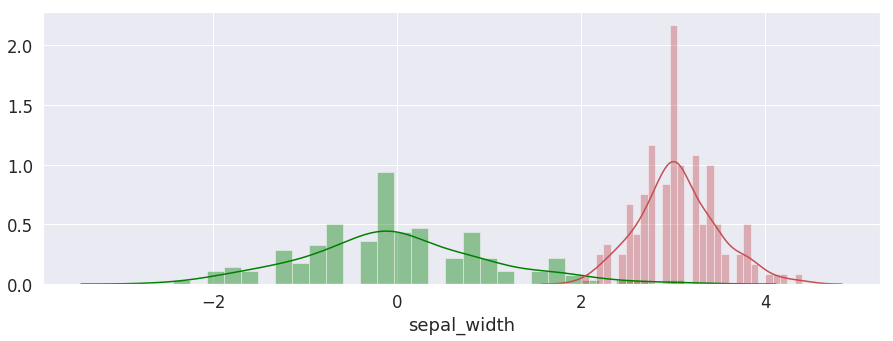

In [243]:
#vari plot di distribuzione
fig,ax=plt.subplots(1,1,figsize=(15,5))
features = df.columns
sns.distplot(scaled_df['sepal_width'],kde=True,bins=30,color='green')
sns.distplot(df['sepal_width'],kde=True,bins=30,color='r')

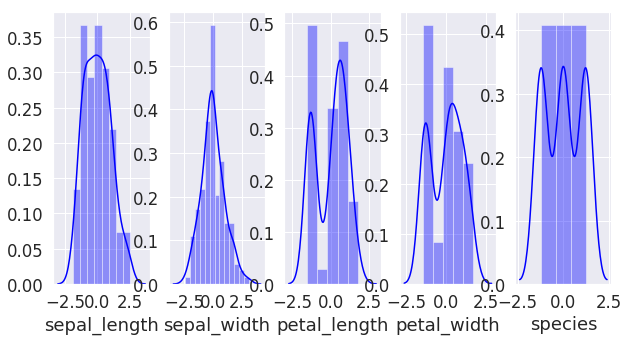

In [244]:
#vari plot di distribuzione
fig,ax=plt.subplots(1,5,figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.distplot(scaled_df.iloc[:,i],kde=True, color='blue')

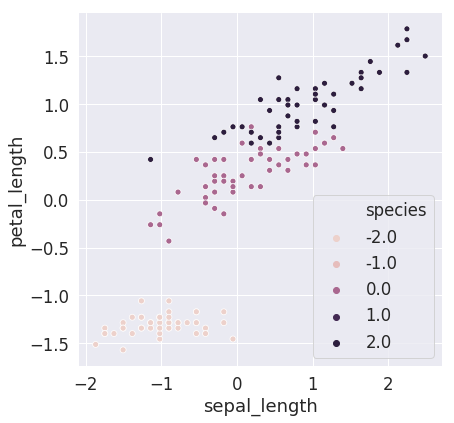

In [245]:
#scatter plot
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="sepal_length", y="petal_length",
                hue="species",data=scaled_df)
plt.show()

In [0]:
#Principal component analysis
X = scaled_df.iloc[:,:-1]
y = scaled_df['species']
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.33, random_state=500)

In [247]:
#K-means
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(X_train)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

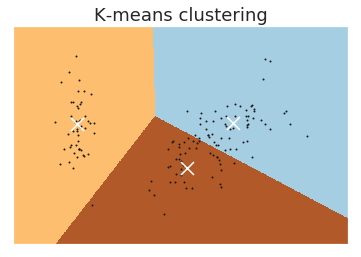

In [248]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_reduced[:, 0], X_reduced[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


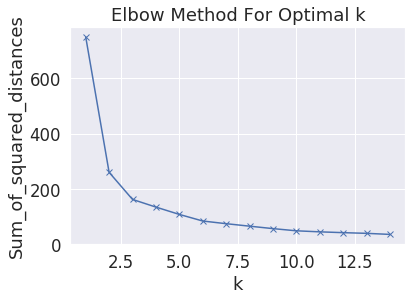

In [249]:

#Scelta del cluster ottimale 
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [250]:

predictions = kmeans.predict(X_test)
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y_test == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))
pred_good = np.where(predictions == 0)[0]
real_good = np.where(y_test == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
false_neg_rate = false_neg/(false_pos+false_neg)
accuracy = (len(X_test) - (false_neg + false_pos)) / len(X_test)
print("Accuracy:", accuracy)
print("False negative rate (with respect to misclassifications): ", false_neg_rate)
print("False negative rate (with respect to all the data): ", false_neg / len(predictions))
print("False negatives, false positives, mispredictions:", false_neg, false_pos, false_neg + false_pos)
print("Total test data points:", len(X_test))

Accuracy: 0.3
False negative rate (with respect to misclassifications):  0.5142857142857142
False negative rate (with respect to all the data):  0.36
False negatives, false positives, mispredictions: 18 17 35
Total test data points: 50


In [251]:
#Classificazione con Xgboost
model = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)
train_model = model.fit(X_train, y_train)
from sklearn.metrics import classification_report
pred = train_model.predict(X_test)
print('Model 1 XGboost Report %r' % (classification_report(y_test.round(), pred.round())))


Model 1 XGboost Report '              precision    recall  f1-score   support\n\n        -1.0       1.00      1.00      1.00        17\n         0.0       0.92      0.86      0.89        14\n         1.0       0.90      0.95      0.92        19\n\n   micro avg       0.94      0.94      0.94        50\n   macro avg       0.94      0.93      0.94        50\nweighted avg       0.94      0.94      0.94        50\n'


In [0]:
cm=confusion_matrix(y_test.round(),pred.round())


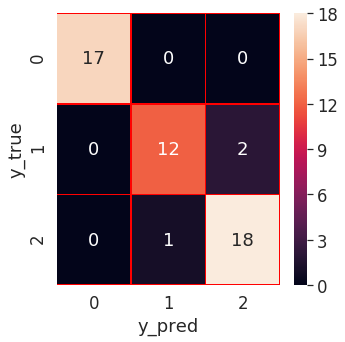

In [253]:

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")

plt.show()

In [265]:
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier()
param_dist = {"max_depth": [1,2,3,4,5,6,7,10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [10,20,50,200],
              "learning_rate": [#0.01,0.02,0.03,0.05 
                  0.1,0.16,0.20,0.50],}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.round())

grid_search.best_estimator_
#Qua cambio e valuto nel modello
model = xgb.XGBClassifier(max_depth=1, min_child_weight=1,  n_estimators=50,\
                          n_jobs=-1 , verbose=1,learning_rate=0.5)
model.fit(X_train,y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0216s.) Setting batch_size=332.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0216s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (6.9892s.) Setting batch_size=166.
[Parallel(n_jobs=-1)]: Done 1498 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (10.8125s.) Setting batch_size=83.
[Parallel(n_jobs=-1)]: Batch computation too slow (5.1727s.) Setting batch_size=41.
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   26.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [266]:
grid_search.best_params_

{'learning_rate': 0.5,
 'max_depth': 1,
 'min_child_weight': 6,
 'n_estimators': 20}

In [0]:
y_scores = model.predict(X_test)

In [271]:
grid_search.best_estimator_
best_est = grid_search.best_estimator_
print(best_est)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=1, min_child_weight=6, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
